# Forecasting time series with gradient boosting: Skforecast, XGBoost, LightGBM, Scikit-learn y CatBoost

Gradient boosting models have gained popularity in the machine learning community due to their ability to achieve excellent results in a wide range of use cases, including both regression and classification. Although these models have traditionally been less common in forecasting, recent research has shown that they can be highly effective in this domain. Some of the key benefits of using gradient boosting models for forecasting include:

1. The ease with which exogenous variables can be included in the model, in addition to autoregressive variables.

2. The ability to capture non-linear relationships between variables.

3. High scalability, allowing models to handle large volumes of data.

4. Some implementations allow the inclusion of categorical variables without the need for one-hot coding.

Despite these benefits, the use of machine learning models for forecasting can present several challenges that can make analysts reluctant to use them, the main ones being

1. Transforming the data so that it can be used as a regression problem.

2. Depending on how many future predictions are needed (prediction horizon), an iterative process may be required where each new prediction is based on previous ones.

3. Model validation requires specific strategies such as backtesting, walk-forward validation or time series cross-validation. Traditional cross-validation cannot be used.

The skforecast library provides automated solutions to these challenges, making it easier to apply and validate machine learning models to forecasting problems. The library supports several advanced gradient boosting models, including XGBoost, LightGBM, Catboost and scikit-learn HistGradientBoostingRegressor. This document shows how to use them to build accurate forecasting models.

![Alt text][def]

[def]: image.png

In [ ]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "seaborn"
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Configuration warnings
# ==============================================================================
import warnings
warnings.filterwarnings("ignore")

The data in this document represent the hourly usage of the bike share system in the city of Washington, D.C. during the years 2011 and 2012. In addition to the number of users per hour, information about weather conditions and holidays is available.

In [ ]:
# Downloading data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-'
       'learning-python/master/data/bike_sharing_dataset_clean.csv')
data = pd.read_csv(url)
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('date_time')
data = data.asfreq('H')
data = data.sort_index()
data = data.drop(columns=['workingday'])
data.head()

In [ ]:
# Split train-validation-test
# ==============================================================================
end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

# EDA

In [ ]:
# Plot time series with zoom
# ==============================================================================
zoom = ('2011-08-01 00:00:00','2011-08-15 00:00:00')

fig = plt.figure(figsize=(8, 4))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.1, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

data_train['users'].plot(ax=main_ax, label='train', alpha=0.5)
data_val['users'].plot(ax=main_ax, label='validation', alpha=0.5)
data_test['users'].plot(ax=main_ax, label='test', alpha=0.5)
min_y = min(data['users'])
max_y = max(data['users'])
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')
main_ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.8))
data.loc[zoom[0]: zoom[1]]['users'].plot(ax=zoom_ax, color='blue', linewidth=1)
main_ax.set_title(f'Number of users: {data.index.min()}, {data.index.max()}', fontsize=10)
zoom_ax.set_title(f'Number of users: {zoom}', fontsize=10)
zoom_ax.set_xlabel('')
plt.subplots_adjust(hspace=1)

In [ ]:
# Interactive plot of time series
# ==============================================================================
data.loc[:end_train, 'partition'] = 'train'
data.loc[end_train:end_validation, 'partition'] = 'validation'
data.loc[end_validation:, 'partition'] = 'test'

fig = px.line(
    data_frame = data.reset_index(),
    x      = 'date_time',
    y      = 'users',
    color  = 'partition',
    title  = 'Number of users',
    width  = 800,
    height = 450
)
fig.update_layout(
    width  = 800,
    height = 400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
fig.update_xaxes(rangeslider_visible=True)
fig.show()
data=data.drop(columns='partition')

In [ ]:
# Daily seasonality - seasonality plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 2))
mean_day_hour = data.groupby(["weekday", "hour"])["users"].mean()
mean_day_hour.plot(ax=ax)
ax.set(
    title="Mean users during week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel="Day and hour",
    ylabel="Number of users"
);

There is a clear difference between weekdays and weekends. There is also a clear intra-day pattern, with different influx of users depending on the time of day.

# Autocorrelation plots
Autocorrelation plots can help identify patterns in your time series data. If the autocorrelation plot shows a high autocorrelation at a particular lag, it indicates that there is a strong relationship between observations at that lag, and therefore that lag may be a useful predictor.

In [ ]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_acf(data['users'], ax=ax, lags=72)
plt.show()

In [ ]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_pacf(data['users'], ax=ax, lags=72, method='ywm')
plt.show()

The results of the autocorrelation study show that there is a significant correlation between the number of users in previous hours, as well as the days before, and the number of users in the future. This means that knowing the number of users during certain periods in the past could be valuable in predicting the number of users in the future.

# XGBOOST

XGBoost is a highly efficient implementation of the stochastic gradient boosting algorithm, which has become a benchmark in the field of machine learning. The XGBoost library includes its own API as well as the XGBRegressor class, which follows the scikit-learn API, making it compatible with skforecast.

First, an autoregressive model is trained using past values (lags) of the response variable as predictors. Later, exogenous variables are added to the model and the improvement in its performance is assessed.

In [ ]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123),
                 lags = 24
             )

In [ ]:
#HYPERPARAMETER TUNING

# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [48, 72]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'users'], # Train and validation data
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 36,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data_train), # Model is trained with training data
                   fixed_train_size   = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False
               )

In [ ]:
# Results of grid search
# ==============================================================================
results_grid.head()

Since return_best = True, the forecaster object will be updated with the best configuration found and trained on the entire dataset. This means that the final model obtained from the grid search will have the best combination of lags and hyperparameters that resulted in the highest performance metric. This final model can then be used for future predictions on new data.

# Backtesting test period

Once the best combination of hyperparameters has been identified using the validation data, the predictive capacity of the model is evaluated when applied to the test set. The backtesting_forecaster function is used to simulate the prediction process every 36 hours.

It is recommended to review the documentation for the backtesting_forecaster function to gain a better understanding of its capabilities. This will help to utilize its full potential to analyze the predictive capacity of the model.

In [ ]:
# Backtesting on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data['users'],
                            initial_train_size = len(data.loc[:end_validation]),
                            fixed_train_size   = False,
                            steps              = 36,
                            refit              = False,
                            metric             = 'mean_squared_error',
                            n_jobs             = 'auto',
                            verbose            = False # Change to True to see detailed information
                      )        

print(f"Backtest error: {metric:.2f}")
predictions.head()

In [ ]:
# Plot predictions vs real value
# ======================================================================================
import plotly.graph_objs as go


fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['users'], name="test", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Real value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="Users",
    width  = 800,
    height = 400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

## Continuous features with a cyclical pattern ##
Continuous features that have a cyclic pattern, such as hours, can be handled in several ways, each with its advantages and disadvantages.

One approach is to use the features directly as numeric values without any transformation. This method avoids generating numerous new features but may impose an incorrect linear order on the values. For example, hour 23 of one day and hour 00 of the next are very far apart when in fact there is only one hour difference between them.

Another possibility is to treat cyclical features as categorical variables to avoid imposing a linear order. However, this approach may result in the loss of the cyclical information inherent in the variable.

There is a third way of dealing with cyclical features that is often preferred to the other two methods. This involves transforming the features using the sine and cosine of their period. This approach generates only two new features that capture the cyclicality of the data in a more accurately than the previous two methods because it preserves the natural order of the feature and avoids imposing a linear order.

In [ ]:
# Transformation sine-cosine of variable hour
# ==============================================================================
data['hour_sin'] = np.sin(data['hour'] / 23 * 2 * np.pi)
data['hour_cos'] = np.cos(data['hour'] / 23 * 2 * np.pi)

# Plot of the transformation
# ==============================================================================
fig, ax = plt.subplots(figsize=(3.5, 3))
sp = ax.scatter(
        data["hour_sin"],
        data["hour_cos"],
        c=data["hour"],
        cmap='viridis'
     )
ax.set(
    xlabel="sin(hour)",
    ylabel="cos(hour)",
)
_ = fig.colorbar(sp)
data = data.drop(columns='hour')

## Categorical features

Although the variables 'month', 'weekday', 'weather' and 'holiday' are stored as numeric values, they are actually categorical variables. Therefore, it is important to convert their data type to categorical to prevent the model from interpreting them as numeric features. This will help ensure that the model is able to accurately capture the unique characteristics and patterns of these variables.

In [ ]:
# Store categorical variables as category type
# ==============================================================================
data["holiday"] = data["holiday"].astype("category")
data["weather"] = data["weather"].astype("category")
data["month"]   = data["month"].astype("category")
data["weekday"] = data["weekday"].astype("category")

There are several approaches to incorporating categorical variables into XGBoost (and other gradient boosting frameworks):

One option is to transform the data by converting categorical values to numerical values using methods such as one-hot encoding or ordinal encoding. This approach is applicable to all machine learning models.

Alternatively, XGBoost can handle categorical variables internally without the need for preprocessing. This can be done automatically by setting the parameter enable_categorical='auto' and encoding the variables as the category datatype within a Pandas DataFrame. Alternatively, users can specify the category type of each feature using the feature_dtype parameter.

## One hot encoding

ColumnTransformers in scikit-learn provide a powerful way to define transformations and apply them to specific features. By encapsulating the transformations in a ColumnTransformer object, it can be passed to a forecaster using the transformer_exog argument.

In [ ]:
# One hot encoding transformer
# ==============================================================================
one_hot_encoder = make_column_transformer(
                      (
                          OneHotEncoder(sparse_output=False, drop='if_binary'),
                          make_column_selector(dtype_exclude=np.number),
                      ),
                      remainder="passthrough",
                      verbose_feature_names_out=False,
                  ).set_output(transform="pandas")

In [ ]:
# Create forecaster with a transformer for exogenous features
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = XGBRegressor(random_state=123),
                 lags             = 24,
                 transformer_exog = one_hot_encoder
             )

In [ ]:
# View Training Matrix
# ==============================================================================
exog_features = ['weather', 'month', 'weekday', 'hour_sin', 'hour_cos', 'holiday',
                 'temp', 'atemp', 'hum', 'windspeed']
                 
X_train, y_train = forecaster.create_train_X_y(
                        y = data.loc[:end_validation, 'users'],
                        exog = data.loc[:end_validation, exog_features]
                   )
X_train.head(3)

In [ ]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [48, 72]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'users'],
                   exog               = data.loc[:end_validation, exog_features],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 36,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False
               )

In [ ]:
# Backtesting test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['users'],
                          exog               = data[exog_features],
                          initial_train_size = len(data.loc[:end_validation]),
                          fixed_train_size   = False,
                          steps              = 36,
                          refit              = False,
                          metric             = 'mean_squared_error',
                          n_jobs             = 'auto',
                          verbose            = False
                      )


### Feature importances
An advantage of avoiding one-hot encoding is that it avoids increasing the number of features, which makes interpretation easier. This can lead to simpler analysis and better understanding of the data as there are fewer variables to consider.

In [ ]:
# Extract feature importances
# ==============================================================================
importance = forecaster.get_feature_importances()
importance

### LightGBM, CatBoost and HistGradientBoostingRegressor
Since the success of XGBoost as a machine learning algorithm, new implementations have been developed that also achieve excellent results, three of them are:

LightGBM: developed by Microsoft.

HistGradientBoostingRegressor: developed by scikit-learn.

CatBoost: developed by Yandex.

In [ ]:
# LightGBM
# Transformer: Ordinal encoding + cast to category type
# ==============================================================================
pipeline_categorical = make_pipeline(
                           OrdinalEncoder(
                               dtype=int,
                               handle_unknown="use_encoded_value",
                               unknown_value=-1,
                               encoded_missing_value=-1
                           ),
                           FunctionTransformer(
                               func=lambda x: x.astype('category'),
                               feature_names_out= 'one-to-one'
                           )
                       )

transformer_exog = make_column_transformer(
                       (
                           pipeline_categorical,
                           make_column_selector(dtype_exclude=np.number)
                       ),
                       remainder="passthrough",
                       verbose_feature_names_out=False,
                   ).set_output(transform="pandas")

In [ ]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(categorical_features='auto', random_state=123),
                lags = 24,
                transformer_exog = transformer_exog
             )

forecaster

In [ ]:
# Grid search of hyperparameters and lags
# ==============================================================================
warnings.filterwarnings('ignore')
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [48, 72]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'users'],
                   exog               = data.loc[:end_validation, exog_features],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 36,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False
               )
warnings.resetwarnings()

In [ ]:
# Backtesting test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['users'],
                          exog               = data[exog_features],
                          initial_train_size = len(data.loc[:end_validation]),
                          fixed_train_size   = False,
                          steps              = 36,
                          refit              = False,
                          metric             = 'mean_squared_error',
                          n_jobs             = 'auto',
                          verbose            = False
                      )

print(f"Backtest error: {metric:.2f}")

### HistGradientBoostingRegressor
When creating a forecaster using HistogramGradientBoosting, the names of the categorical columns should be specified during the instantiation of the regressor by passing them as a list to the categorical_feature argument.

In [ ]:
# Transformer: ordinal encoding
# ==============================================================================
# A ColumnTransformer is used to transform categorical features (no numerical)
# using ordinal encoding. Numerical features are left untouched. Missing values
# are encoded as -1. If a new category is found in the test set, it is encoded
# as -1.
categorical_features = data.select_dtypes(exclude=[np.number]).columns.tolist()
transformer_exog = make_column_transformer(
                       (
                           OrdinalEncoder(
                               dtype=int,
                               handle_unknown="use_encoded_value",
                               unknown_value=-1,
                               encoded_missing_value=-1
                           ),
                           categorical_features
                       ),
                       remainder="passthrough",
                       verbose_feature_names_out=False,
                   ).set_output(transform="pandas")

In [ ]:
# Create forecaster
# ==============================================================================
categorical_features = data.select_dtypes(exclude=np.number).columns.to_list()

forecaster = ForecasterAutoreg(
                 regressor = HistGradientBoostingRegressor(
                                 categorical_features = categorical_features,
                                 random_state = 123
                             ),
                 lags = 24,
                 transformer_exog = transformer_exog
             )

forecaster

In [ ]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'max_iter': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [48, 72]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'users'],
                   exog               = data.loc[:end_validation, exog_features],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 36,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False
               )

In [ ]:
# Backtesting test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['users'],
                          exog               = data[exog_features],
                          initial_train_size = len(data.loc[:end_validation]),
                          fixed_train_size   = False,
                          steps              = 36,
                          refit              = False,
                          metric             = 'mean_squared_error',
                          n_jobs             = 'auto',
                          verbose            = False
                      )

print(f"Backtest error: {metric:.2f}")

### CatBoost


Unfortunately, the current version of skforecast is not compatible with CatBoost's built-in treatment of categorical features. The issue arises because CatBoost only accepts categorical features as integers, while skforecast converts input data to floats for faster computation using numpy arrays in the internal prediction process. To work around this limitation, it is necessary to apply either the one-hot encoding or label encoding strategy to the categorical features before using them with CatBoost.

In [ ]:
# One hot encoding
# ==============================================================================
one_hot_encoder = make_column_transformer(
                      (
                          OneHotEncoder(sparse_output=False, drop='if_binary'),
                          make_column_selector(dtype_exclude=np.number),
                      ),
                      remainder="passthrough",
                      verbose_feature_names_out=False,
                  ).set_output(transform="pandas")

In [ ]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = CatBoostRegressor(
                                        random_state=123, 
                                        silent=True, 
                                        allow_writing_files=False
                                    ),
                 lags             = 24,
                 transformer_exog = one_hot_encoder
             )

forecaster

In [36]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [48, 72]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'users'],
                   exog               = data.loc[:end_validation, exog_features],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 36,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                    n_jobs            = 'auto',
                   verbose            = False
               )

In [ ]:
# Backtesting test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['users'],
                          exog               = data[exog_features],
                          initial_train_size = len(data.loc[:end_validation]),
                          fixed_train_size   = False,
                          steps              = 36,
                          refit              = False,
                          metric             = 'mean_squared_error',
                          n_jobs             = 'auto',
                          verbose            = False
                      )

print(f"Backtest error: {metric:.2f}")

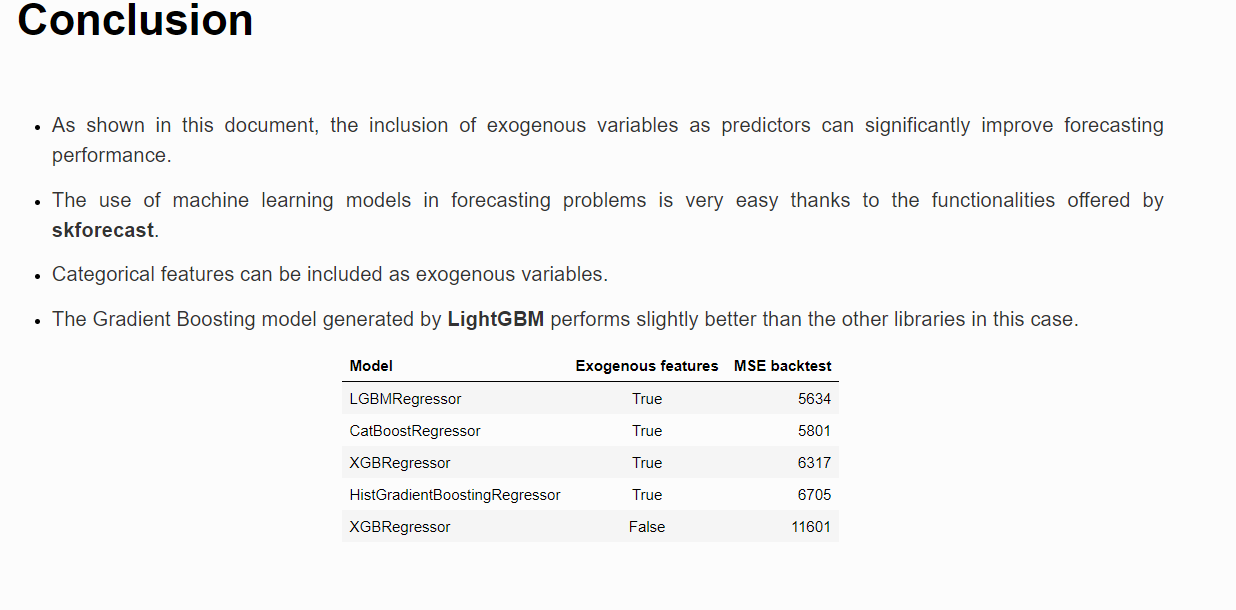